# FOSM, data worth and related assessments

First Order Second Moment (FOSM), sometimes referred to as linear analysis, provides insights into the decision-support modelling process which are not possible to obtain in any other way. Outcomes are approximate. This is because relationships between groundwater model outputs and parameters are not in fact linear. 

Undertaking linear analysis requires:
 - A Jacobian matrix; 
 - The prior parameter covariance matrix;
 - The covariance matrix of measurement noise.

Linear analysis can be accomplished with software from the PEST utilities, PEST++GLM or pyEMU and can be performed before and/or after calibration. It relies on the existence of a Jacobian (sensitivity) matrix, which is calculated by PEST/PEST++ by perturbing parameters by a small amount from their initial value. This requires a single model run for each adjustable parameter. Prior parameter and measurement noise covariance matrices must also be provided by the user.

FOSM tasks may include:
 - approximate parameter and predictive uncertainty quantification;
 - data worth analysis;
 - assist in identifying parameters that are most salient for forecasts of interest, 
 - identify parameter contributions to predictive uncertainty and 
 - assess parameter identifiability. 

Visual outcomes of these analyses can provide easily understood insights into what history-matching can achieve, and what it cannot achieve due to lack of information. This can be used to streamline the data assimlation process and guide further site characterisation studies by ensuring effective data collection targeted at reducing the uncertainties of predictions that matter. 

Data worth analysis identifies relative observation contributions to reducing forecast uncertainty and is “forecast specific”. The value of each observation is compared in terms of its ability to reduce uncertainty of a unique forecast. Assessing data worth does not require that a measured value already be known. Thus it can be a useful tool when prioritizing what new data to collect. There are a few things to consider when including data worth set up as part of a modelling workflow:
 - any potential new data being assessed must be simulated by the model.
 - a Jacobian matrix must be calculated that links parameter changes to changes in the pontential new observation values. 
 
Thus, it is often useful to think about potential new data early on in the modelling workflow. This allows the modeller to pre-emptively include potential new observations in the PEST dataset with zeroweight (i.e. they do not affect history matching) for later use. 

### The current tutorial
 
In this notebook, we will use outputs from previous notebooks (in particular `freyberg_glm_1.ipynb`) to undertake data worth assessments based on first-order second-moment (FOSM) techniques. "Worth" is framed here in the context of the extent to which the uncertainty surrounding a model prediction of management interest is reduced through data collection.  Given that these anayses can help target and optimize data acquisition strategies, this is a concept that really resonates with decision makers.

Note that in this tutorial, we will demonstrate FOSM applied __before__ calibration (i.e. as an optional intermediate step between the `freyberg_glm_1.ipynb` and `freyberg_glm_2.ipynb` notebooks), as several of these techniques can be a usefull tools that aid in the design of the calibration setup. However, they are equaly applicable __after__ calibration. In the `freyberg_glm_2.ipynb` notebook, some outcomes of post-calibration FOSM are discussed. 

Here we will be using functionality in `pyemu` to undertake FOSM. Similar analyses can be undertaken with the PREDUNC and PREDVAR suite of PEST utilities (see the [GMDSI](https://gmdsi.org/education/tutorials/) website for tutorials on these utilities). 

### Admin

Start off with the usual loading of dependencies and preparing model and PEST files. We will be continuing to work with the MODFLOW6 modified-Freyberg model (see "freyberg intro to model" notebook), and the high-dimensional PEST dataset prepared in the "freyberg_glm_1" notebook. For the purposes of this notebook, you do not require familiarity with previous notebooks (but it helps...). 

Simply run the next few cells by pressing `shift+enter`.

In [82]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
plt.rcParams.update({'font.size': 8})

import shutil 
import scipy.stats as stats
import math

import sys
sys.path.append(os.path.join("..", "..", "dependencies"))
import pyemu
import flopy

We are going to make use of the outcomes of the "freyberg_glm_1" tutorial, in which we ran `PEST++GLM` to calculate the jacobian matrix prior to calibration. If you ran the notebook yourself, they should be recorded in the folder named "master_glm_1".

Let's start by specifying the folder path:

In [83]:
m_d = os.path.join("..","part2_4_glm","master_glm_1")

# a check to see if the files are avilable
if not os.path.exists(m_d):
    raise Exception("you need to run the '/part2_4_glm/freyberg_glm_1.ipynb' notebook")

OK, now let's read in our PEST control file and take a peek just to recall what is is we are working with:

In [84]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_pp.pst"))
print('adjustable parameters:',pst.npar_adj,'\nnonzero observations:', pst.nnz_obs)
#pst.write_par_summary_table(filename="none")

adjustable parameters: 415 
nonzero observations: 144


### Getting ready for FOSM

Recall we need three ingredients for FOSM:
 - parameter covariance matrix 
 - observation noise covariance matrix
 - jacobian matrix 

Let's start with the parameter covariance matrix. In this instance, our covariance matrix represents the prior parameter uncertainty. We prepared and recorded a prior covariance matrix when we constructed the PEST dataset (see the "pstfrom_pest_setup" tutorial). It is recorded in the file named `prior_cov.jcb`. 

Let's read it in a as a `pyemu.Cov` object:

In [85]:
# read the file
cov = pyemu.Cov.from_binary(os.path.join(m_d,"prior_cov.jcb")).to_dataframe()
# the prior was constructed for the high-dimensional dataset; 
# but we had to drop lots of parameters to undertake GLM (see "freyberg_glm_1" tutorial)
# so we need to slice cov to get only adjustable parameter cols/rows
cov = cov.loc[pst.adj_par_names,pst.adj_par_names]
# and then rebuild it
cov = pyemu.Cov.from_dataframe(cov)

Take a quick peek:

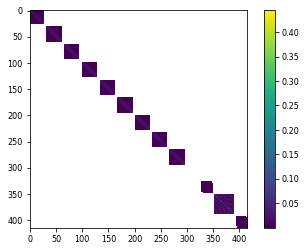

In [86]:
# let's inspect only
x = cov.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar()

The second ingredient we need is the jacobian matrix. In a previous tutorial, we ran `PEST++GLM` with the `fresyberg_pp.pst` control file to calculate the jacobian for intial parameter values and then stop (by setting `NOPTMAX` to -1). It is stored in the binary file named `freyberg_pp.jcb`.

Let's read it in as a `pyemu.Jco`:

In [87]:
jco_file = os.path.join(m_d,"freyberg_pp.jcb")

jco = pyemu.Jco.from_binary(jco_file)

Lastly, we are still missing the noise covariance matrix. Unless instructed otherwise, `pyemu` will construct this matrix on-the-fly using weights in the PEST control file (and assuming that weights are the inverse of the standard deviation). 

Alternatively you can provide a user created (diagonal!) covariance matrix. In our case weights reflect measurment uncertaint. But just for the sake of demosntration, let's generate an observation covarance matrix from the control file:

In [88]:
obscov = pyemu.Cov.from_observation_data(pst)

The `Schur` object is one of the primary object for FOSM in pyEMU. It is the starting point for most things FOSM in the `pyemu` world. We are going to pass in our ingredients to instantiate a `Schur` object.

Now...`pyemu` is clever and does its best to reduce the amount of information you need to pass explicitly. Minimum requirements are the `Pst` and `Jco`. If not explicitly provided, the (diagonal) observation covariance matrix will be calculated from observation weights in `pst`. If present, forecasts will be populated from the list of `pst.forecast_names`.

However, here we will demonstrate by passing each ingredient explicitly:

In [89]:
sc = pyemu.Schur(pst=pst, # the pest control file
                jco=jco, # the jacobian matrix
                parcov=cov, # the parameter covariance matrix; if not provided pyemu calculates from parameter bounds
                obscov=obscov, # the obs noise cov matrix; necessary if obs weights in the pst do not reflect uncertainty
                forecasts=pst.forecast_names # forecast observation names
                )

sc

So that was easy...but maybe not the standard use case.  In many modeling analyses, there will be a separate scenario model - it is this model that will yield the forecast sensitivity vector(s) needed to map parameter uncertainty to forecast uncertainty.  That is, you will need to run the scenario model once for each adjustble parameter to fill a separate jacobian -  jacobian that has the same columns as the obervation jacobian, but has rows that are the forecasts.  

In these cases you would have a (1) jacobian that pertains to the history matching model, and (2) a jacobian that pertains to the scenario model. For the purposes of FOSM, you would be interested in the sensitivities of history-matching observations recorded in (1) and sensitivities of forecast observations recorded in (2).

Now we didnt do that here - our model forward run includes both the history matching and scenario periods. So our jacobian already contains both sets of sensitivities. But we can "fake" it just for the sake of demonstration. Let's pretend that we have a second jacobian calculated using a scenario model:


In [90]:
pretend_second_jco = pyemu.Jco.from_binary(jco_file)


Now we extract the forecast rows from the full jacobian:

In [91]:
forecast_jco = pretend_second_jco.get(row_names=pst.forecast_names, drop=True)

In [92]:
# shape: number of obs rows, number of par columns
forecast_jco.shape, jco.shape

((4, 415), (4623, 415))

In [93]:
sc = pyemu.Schur(pst=pst, # the pest control file
                jco=jco, # the jacobian matrix
                parcov=cov, # the parameter covariance matrix; if not provided pyemu calculates from parameter bounds
                obscov=obscov, # the obs noise cov matrix; necessary if obs weights in the pst do not reflect uncertainty
                forecasts=forecast_jco.T # forecast sensitivity vectors
                )

Boom - easy! 

All computations are done and contained within `sc`.  We can now access different parts of `sc`. 

### Posterior Parameter Uncertainty

Let's start by calculating the (approximate) __posterior__ parameter covariance matrix. Here, we are updating parameter covariance following notional calibration as represented by te Jacobian matrix and both prior parameter and observation noise covariance matrices. 

In other words, given prior parameter uncertainty (expressed by the prior `cov` matrix) and the inherent noise in measurments (expressed by the `obscov` matrix), we calculate the expected parameter uncertainty __after__ calibration. This assumes that calibration achieves a fit comensurate with measurement noise, parameter linearity, etc.

The posterior parameter covariance is stored as a `pyemu.Cov` object in the `sc.posterior_parameter` attribute:

In [94]:
sc.posterior_parameter

The diagonal of this matrix contains the posterior __variance__ for each parameter. The off-diagonals the parameter covariances. 

In [95]:
# display a slice of the cov matrix
sc.posterior_parameter.to_dataframe().sort_index().sort_index(axis=1).iloc[0:3,0:3] 

,pname:ghbcondcn_inst:0_ptype:cn_usecol:4_pstyle:m,pname:ghbheadcn_inst:0_ptype:cn_usecol:3_pstyle:a,pname:nelayer1cn_inst:0_ptype:cn_pstyle:m
pname:ghbcondcn_inst:0_ptype:cn_usecol:4_pstyle:m,0.088915,0.032815,0.000000
pname:ghbheadcn_inst:0_ptype:cn_usecol:3_pstyle:a,0.032815,0.068914,0.000000
pname:nelayer1cn_inst:0_ptype:cn_pstyle:m,0.000000,0.000000,0.054284


Let's make a little work of art - a plot of the posterior cov matrix. As expected, we see posterior variance along the diagonal and off-diagonals are symmetric:

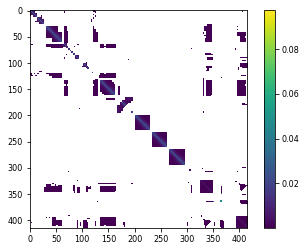

In [96]:
x = sc.posterior_parameter.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar(c)

But...is calibration worth pursuing or not? Let's explore what the notional calibration is expected to do for parameter uncertainty. We accomplish this by comparing parior and posterior parameter uncertainty. Using `.get_parameter_summary()` makes this easy:

In [97]:
par_sum = sc.get_parameter_summary().sort_values("percent_reduction",ascending=False)
par_sum.head()

,prior_var,post_var,percent_reduction
pname:ghbheadcn_inst:0_ptype:cn_usecol:3_pstyle:a,0.444444,0.068914,84.494432
pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,0.111111,0.017411,84.330237
pname:stosylayer1cn_inst:0_ptype:cn_pstyle:m,0.054284,0.009695,82.141109
pname:npfklayer3cn_inst:0_ptype:cn_pstyle:m,0.054284,0.011166,79.430629
pname:npfk33layer2cn_inst:0_ptype:cn_pstyle:m,0.054284,0.018942,65.106649


As the name suggests, the `percent_reduction` column in `par_sum`shows the percentage decrease in uncertainty achievable through calibration for each parameter.

For example, we can plot up the best ten:

Text(0.5, 1.0, 'Percent Reduction')

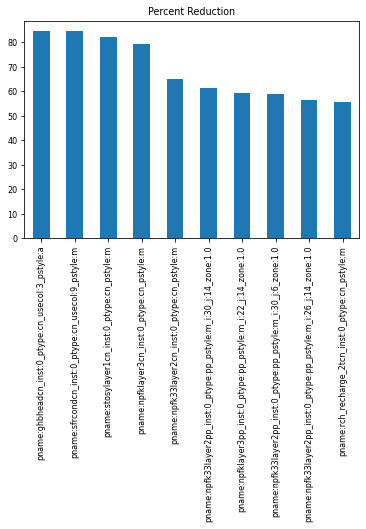

In [98]:
# we can plot up the top 10 uncertainty reductions
par_sum.iloc[0:10,:]['percent_reduction'].plot(kind='bar')
plt.title('Percent Reduction')

Alternatively we can compare the prior and posterior variances for the best ten:

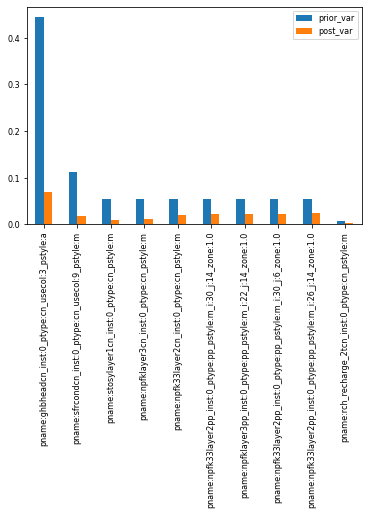

In [99]:
# we can plot up the prior and posterior variance 
# of the top 10 percent reductions
par_sum.iloc[0:10,:][['prior_var','post_var']].plot(kind='bar');

From the two plots above we can see that calibrating the model with available data reduces uncertainty of some parameters.

Let's look at the other end of the spectrum - parameters for which there was little uncertainty reduction. Let's insepect the end of the parameter summary dataframe:

In [100]:
par_sum.iloc[-5:,:]

,prior_var,post_var,percent_reduction
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:2_j:6_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:26_j:2_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:34_j:14_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer1pp_inst:0_ptype:pp_pstyle:m_i:22_j:10_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer1pp_inst:0_ptype:pp_pstyle:m_i:26_j:2_zone:1.0,0.054284,0.054284,-4.440892e-14


Hmm - looks like there are some parameters which are not informed by calibration. Not surprising. For example, we are adjusting porosity values, but have no calibration observations which are affected by porosity...

In [101]:
par_sum.tail()

,prior_var,post_var,percent_reduction
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:2_j:6_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:26_j:2_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:34_j:14_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer1pp_inst:0_ptype:pp_pstyle:m_i:22_j:10_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer1pp_inst:0_ptype:pp_pstyle:m_i:26_j:2_zone:1.0,0.054284,0.054284,-4.440892e-14


Let's make a quick check of what parameter groups these un-informed parameters are part of:

In [102]:
# get list of parnames with <1% uncert reduction; 1% is an arbitrary subjective choice...
uninf_par_names = par_sum.loc[par_sum['percent_reduction']<1].index.values

# get corresponding par group names
pst.parameter_data.loc[uninf_par_names, 'pargp'].unique()

array(['npfklayer2pp', 'welcst', 'npfklayer1pp', 'sfrgr', 'npfklayer2cn',
       'stosslayer3pp', 'stosslayer3cn', 'stosslayer2cn', 'nelayer1pp',
       'nelayer3pp', 'nelayer2pp', 'rch_recharge_23tcn',
       'rch_recharge_22tcn', 'nelayer1cn', 'rch_recharge_24tcn',
       'rch_recharge_21tcn', 'rch_recharge_25tcn', 'rch_recharge_20tcn',
       'nelayer3cn', 'rch_recharge_19tcn', 'rch_recharge_18tcn',
       'rch_recharge_17tcn', 'rch_recharge_16tcn', 'nelayer2cn',
       'rch_recharge_15tcn', 'rch_recharge_14tcn'], dtype=object)

So, not too surprising to see porosity parameters groups as well as parameters for recharge in the prediction period. Others, such as storage and permeability parameter groups, indicate that available observation data is not informative for the entire model domain.

When working with spatially ditributed parameters, it can be informative to map the distribution of uncertainty reduction. For example, let's use some `flopy` trickery to plot the % uncertainty reduction for a set of pilot point parameters:

In [103]:
# choose a pilot point parmaeter group
pargp = 'npfklayer3pp'

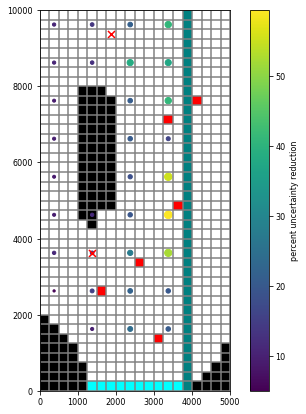

In [104]:
#get pars
hk_pars = pst.parameter_data.loc[pst.parameter_data.pargp==pargp]
hk_pars[['i','j']] = hk_pars[['i','j']].astype(int)
hk_parsum=par_sum.loc[hk_pars.parnme, 'percent_reduction']

# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=m_d, verbosity_level=0)
# load flow model
gwf = sim.get_model()

# plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

# Plot grid 
mm.plot_grid()
mm.plot_inactive()
mm.plot_bc('ghb')
mm.plot_bc('sfr')

# plot ppoints and % unc reduction
pp_x = [gwf.modelgrid.xcellcenters[r-1,c-1] for r,c in hk_pars.loc[:,["i","j"]].values]
pp_y = [gwf.modelgrid.ycellcenters[r-1,c-1] for r,c in hk_pars.loc[:,["i","j"]].values]
scatter = ax.scatter(pp_x,pp_y,marker='o', s=hk_parsum, c=hk_parsum)
plt.colorbar(scatter,label="percent uncertainty reduction")

# plot head obsveration points
obs_ij = list(set([tuple(i.split('-')[-2:]) for i in pst.nnz_obs_groups if 'trgw' in i]))
obs_x = [gwf.modelgrid.xcellcenters[int(i[0])-1,int(i[-1])-1] for i in obs_ij]
obs_y = [gwf.modelgrid.ycellcenters[int(i[0])-1,int(i[-1])-1] for i in obs_ij]
ax.scatter(obs_x,obs_y,marker='x', c='red', s=50)

# Plot wells in layer 3
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=2)
mm.plot_bc('wel');

As expected, much of the uncertainty reduction for hydraulic conductivity is located around head observation wells (red crosses) and the SFR boundary - both of which we have observation data for. More importantly, we can see that uncertainty in the west is not reduced much. So our existing data does not provide much information on these areas. Uncertainty here will only be constrained by our expert knowledge (i.e. the prior).

## Forecast Uncertainty

So far we have seen that some parameter uncertainty will be reduced. Uncertainty for other parameters will not be reduced. That's great and all, but what we really care about are our forecast uncertainties. Do the parameters that are informed by calibration affect the forecast of interest? And will calibrating reduce the uncertainty of the forecast?

Let's examine the prior and posterior variance of our forecasts. Recall that these are recorded as observations in the `Pst` control file and also listed in the pest++ `forecast` control variable:

In [105]:
forecasts = sc.pst.forecast_names
forecasts

['oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
 'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
 'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
 'part_time']

As before, `pyemu` has already done much of the heavy-lifting. We can get a summary of the forecast prior and posterior variances with `.get_forecast_summary()`:

In [106]:
df = sc.get_forecast_summary()
df

,prior_var,post_var,percent_reduction
oname:sfr_otype:lst_usecol:tailwater_time:4383.5,1.750545e+05,3.393013e+04,80.617393
oname:sfr_otype:lst_usecol:headwater_time:4383.5,8.510625e+04,2.761468e+04,67.552694
oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,2.466010e-01,4.404339e-02,82.139820
part_time,9.503174e+10,2.854639e+10,69.961201


And we can make a cheeky little plot of that. As you can see, unsurprisingly some observations benefit more from calibration than others. So, depending on the foreacst of interest, calibration may or may not be worthwhile...

Text(0.5, 0, 'forecast')

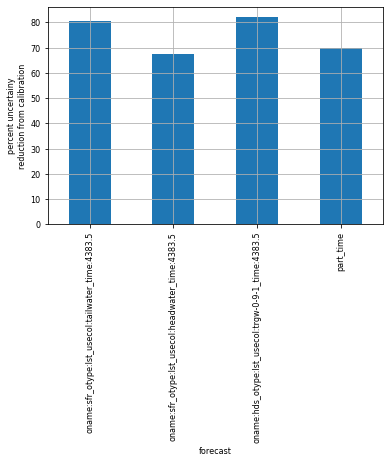

In [108]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure()
ax = plt.subplot(111)
ax = df.percent_reduction.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
#plt.tight_layout()

## Parameter contribution to forecast uncertainty

Information flows from observations to parameters and then out to forecasts. Information contained in observation data constrains parameter uncertainty, whcich in turn constrains forecast uncertainty. For a given forecast, we can evaluate which information contributes the most to uncertainty. This is accomplished by assuming a parameter (or group of parmaeters) is perfectly known and assessing forecast uncertainty under that assumption. Comparing this uncertainty to the forecast uncertainty under the base assumption in which no parameter is perfectly known, the contribution from that parameter (or parameter group) is obtained. 

Now, this is a pretty big assumption - in practice a parameter is never perfectly known. Nevertheless, this metric can provide usefull insights into the flow of information from data to forecast uncertainty, which can help guide data assimilation design as well as future data collection efforts. 

In `pyemu` we can  evaluate parameter contributions to forecast uncertainty with groups of parameters by type using `.get_par_group_contribution()`:

In [109]:
par_contrib = sc.get_par_group_contribution()
par_contrib.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,33930.125274,27614.683871,0.044043,2.854639e+10
ghbcondcn,33902.173664,27079.363415,0.043519,2.850600e+10
ghbheadcn,27144.451519,27430.196631,0.041844,2.356040e+10
nelayer1cn,33930.125274,27614.683871,0.044043,2.854287e+10
nelayer1pp,33930.125274,27614.683871,0.044043,2.854405e+10


To see the relatve contribution by normalizing to the base case (e.g. in which no parameters/groups are perfectly known):

In [110]:
base = par_contrib.loc["base",:]
par_contrib = 100.0 * (base - par_contrib) / base
par_contrib.sort_index().head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
ghbcondcn,8.237992e-02,1.938536e+00,1.189812e+00,0.141487
ghbheadcn,1.999896e+01,6.680766e-01,4.993621e+00,17.466279
nelayer1cn,-4.288789e-14,-2.634815e-14,3.150935e-14,0.012360
nelayer1pp,6.433184e-14,1.844370e-13,2.993389e-13,0.008211


Now it is a simple matter to plot these up for each forecast. Remember! Parameter contributions to uncertainty are forecast specific. The plots below display the top ten parameter groups that contribute to each forecast's uncertainty. Note that different forecasts are affected by different parameters. 


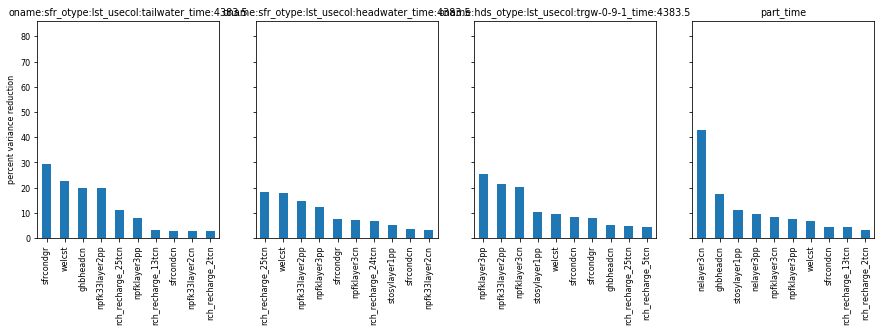

In [111]:
plt.figure(figsize=(15,4))
i=1
for forecast in par_contrib.columns:
    fore_df = par_contrib.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = plt.subplot(1,4,i, sharey=ax)
    i+=1
    fore_df.iloc[:10].plot(kind="bar",color="tab:blue", ax =ax)
    ax.set_title(forecast)
    ax.set_ylabel("percent variance reduction")
    #plt.show()

Understanding the links between parameters and forecast uncertainties can be usefull - in particular to gain insight into the system dynamics. But we are still missing a step to understand what _observation_ data affects the forecast. It is often more straightforward to quantify how observation information imapcts forecast uncertianty so that we can explore the worth of observation data directly.

# Data worth analysis

The worth of data is measured by their ability to reduce the uncertainties of model predictions that we care about. Linear analysis is particularly useful for exploring data worth. This is because the equations that it uses to calculate predictive uncertainty do not include terms that represent the actual values of observations or of parameters; only sensitivities of model outputs to parameters are required. Therefore, linear analysis can be used to assess the ability (or otherwise) of yet-ungathered data to reduce the uncertainties of decision-critical predictions.

This means that potential field measurements that correspond to one or many outputs of a model can be assessed for their worth. For example, it is possible to assess the worth of observations of head in every single model cell at every time step of a model run with a relatively small computational burden. This makes linear analysis a useful tool for designing and comparing strategies for data-collection, when data acquisition seeks to reduce the uncertainties of one or a number of decision-critical predictions. 

There are two main applications for data worth analysis:
 1.	ranking of the relative worth of existing observations by calculating predictive uncertainty with selected individual or combined observations removed from a calibration dataset. 
 2.	ranking of the relative worth of __potential__ new observations by calculating predictive uncertainty with selected individual or combined observations added to an existing calibration dataset.


## Data worth - evaluating existing observations

Here we identify which (existing) observations are most important to reducing the posterior uncertainty of a specific forecast. To acomplish this, we simply need to recalculate the Schur complement, but ignoring some of the observation sensitivities. 

Once again, `pyemu` makes this easy for us with the `get_removed_obs_importance()` method.  This method tests how important individual __non-zero__ observations are for reducing uncertainty for each forecast observation. By default, it tests all non-zero obsevrations in the control file and returns a `Dataframe`:


In [112]:
df_worth = sc.get_removed_obs_importance()
df_worth.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,33930.125274,27614.683871,0.044043,2.854639e+10
oname:hds_otype:lst_usecol:trgw-0-26-6_time:3683.5,33950.824708,27614.697820,0.044057,2.856631e+10
oname:hds_otype:lst_usecol:trgw-0-26-6_time:3712.5,33951.017753,27614.685268,0.044047,2.856013e+10
oname:hds_otype:lst_usecol:trgw-0-26-6_time:3743.5,33931.216441,27621.510220,0.044056,2.856571e+10
oname:hds_otype:lst_usecol:trgw-0-26-6_time:3773.5,33933.601904,27641.881032,0.044100,2.856961e+10


It may be more usefull to look at groupings of observations. For example, in our case we are dealing with time series of measurments at different locations. It may be more usefull to assess the worth of the entire time series of data, and not just each individual measurement. 

We can assess groupings of observations by passsing a dictionary with non-zero observation name lists as values. Let's first create such a dictionary. In our case, the time series of observations from each site is in a distinct observation group. So we can simply group observations by observation group name:

In [113]:
obs_nz = sc.pst.observation_data.loc[pst.nnz_obs_names]
nn_obs_dict={}
for obsgp in pst.nnz_obs_groups:
    values = obs_nz.loc[obs_nz.obgnme==obsgp, 'obsnme'].tolist()
    nn_obs_dict[obsgp]=values

And now recalculate data worth using the dictionary:

In [114]:
dw_rm = sc.get_removed_obs_importance(nn_obs_dict)
dw_rm.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,33930.125274,27614.683871,0.044043,2.854639e+10
oname:hds_otype:lst_usecol:trgw-0-26-6,34410.006305,27785.873317,0.044431,2.891126e+10
oname:hds_otype:lst_usecol:trgw-0-3-8,34330.187564,27717.331599,0.044546,2.860607e+10
oname:hds_otype:lst_usecol:trgw-2-26-6,34431.526801,27799.711503,0.044393,2.890557e+10
oname:hds_otype:lst_usecol:trgw-2-3-8,34229.369491,27696.294706,0.044697,2.860467e+10


The `base` row contains the results of the Schur's complement calculation using all observations (so the forecast unceratainty assuming all observation data is used for calibration). Subsequently, there  is a row for each non-zero obsevration group. Each row lists forecast uncertainties calculated assuming that the observation group was __not__ used for history matching. 

We can normalize the importance of each row to the base case (i.e. the lowest uncertainty, or maximum uncertainty reduction), provinding a easy to interpret metric of importance. We can then quickly identify which observation/observation grouping are important for reducing forecast uncertainty:

In [115]:
# let's normalize to make more meaningful comparisons of data worth (unctainty variance reduction)
base = dw_rm.loc["base",:]
dw_rm = 100 * (dw_rm  - base) / base
dw_rm.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,0.000000,0.000000,0.000000,0.000000
oname:hds_otype:lst_usecol:trgw-0-26-6,1.414321,0.619922,0.880316,1.278149
oname:hds_otype:lst_usecol:trgw-0-3-8,1.179077,0.371714,1.140253,0.209058
oname:hds_otype:lst_usecol:trgw-2-26-6,1.477747,0.670033,0.794370,1.258217
oname:hds_otype:lst_usecol:trgw-2-3-8,0.881943,0.295534,1.483889,0.204158


Let's plot the ten most important observations for each forecast. 

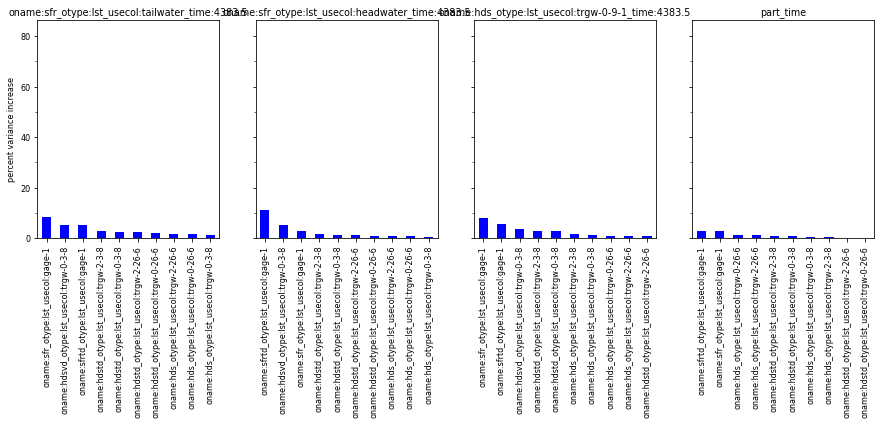

In [79]:
plt.figure(figsize=(15,4))
i=1
for forecast in dw_rm.columns:
    ax = plt.subplot(1,4,i, sharey=ax)
    i+=1
    fore_df = dw_rm.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    fore_df.iloc[:10].plot(kind="bar",color="b", ax=ax)
    ax.set_title(forecast)
    ax.set_ylabel("percent variance increase")
plt.show()

We also have the option of calculating the worth of obsverations by taking a "base" condition of zero observations (i.e. no measurment information at all) and calculating the reduction in uncertainty by __adding__ observations to the dataset.

Here we are obtaining a measure of the worth of the observation __on its own__. This provides a metric of the absolute worth of information contained by the observation. The previous metric (of removed importance) provides a measure of the worth that the observation contributes to the existing dataset; so how much more information do we gain by also including this observation. 

In summary, the importance calculated by __removing__ an observation provides a measure of the extra information gained by including that observation into an existing dataset. The importance calculated by __adding__ an observation provides a measure of the total information content of a single obsveration (or group of observations).

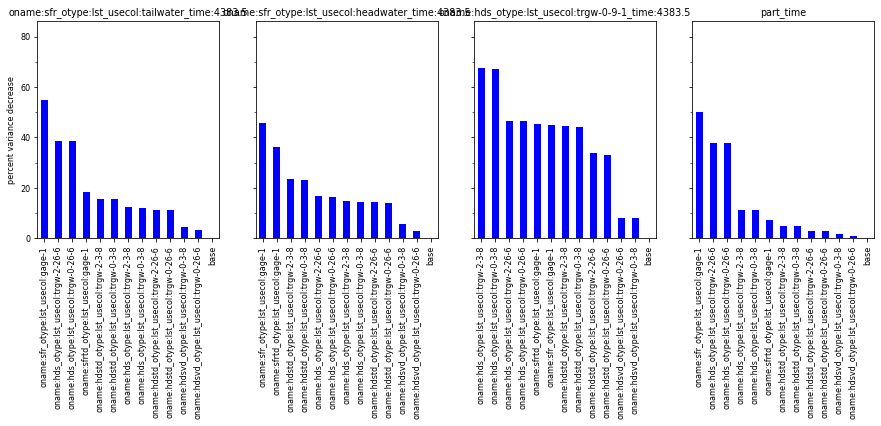

In [80]:
dw_ad = sc.get_added_obs_importance(nn_obs_dict)
base = dw_ad.loc["base",:]
dw_ad = 100 * (base - dw_ad) / base
plt.figure(figsize=(15,4))
i=1
for forecast in dw_ad.columns:
    ax = plt.subplot(1,4,i, sharey=ax)
    i+=1
    fore_df_ad = dw_ad.loc[:,forecast].copy()
    fore_df_ad.sort_values(inplace=True, ascending=False)
    fore_df_ad.iloc[:20].plot(kind="bar",color="b", ax=ax)
    ax.set_title(forecast)
    ax.set_ylabel("percent variance decrease")
plt.show()

## Data worth - the value of potential new observations

This is where things get really cool. As previously mentioned, the equations on which FOSM is based do not rely on knowing the values of observations - only their sensitivities. This allows us to calculate the worth of as-of-yet uncollected data. 

Recall from the "pstfrom_pest_setup" tutorial that we included the simulated head in every cell at the end of every stress period as observations in our PEST dataset. (We included a function to extract these values from the MODFLOW6 generated outputs as part of the model forward run.) We have been "carrying" these zero-weighted observations all this time. Therefore, we can repeat our analysis of the worth of "adding" these observations to the dataset by simply "turning them on".

Cell-by-cell head obsvervations are in the observation groups named `hdslay1`, `hdslay2` and `hdslay3`. For the sake of this tutorial, let's focus on `hdslay3` - cell-by-cell heads in the deeper layer3.

In [125]:
obs = sc.pst.observation_data
obsnames = obs.loc[obs.oname=='hdslay1','obsnme'].tolist()

obsnames[:5]

['oname:hdslay1_otype:arr_i:0_j:0',
 'oname:hdslay1_otype:arr_i:0_j:1',
 'oname:hdslay1_otype:arr_i:0_j:10',
 'oname:hdslay1_otype:arr_i:0_j:11',
 'oname:hdslay1_otype:arr_i:0_j:12']

In [118]:
obs = sc.pst.observation_data
obs.oname.unique()

array(['hds', 'sfr', 'hdslay1', 'hdslay2', 'hdslay3', 'inc', 'cum',
       'sfrtd', 'hdstd', 'hdsvd', nan], dtype=object)

In [ ]:
obs.time.astype(float).unique()[12]

In [ ]:
end_hist_time = obs.time.astype(float).unique()[12]
potential_obs = obs.loc[(obs.oname=='hds') & (obs.time.astype(float)<= end_hist_time), 'obsnme'].tolist()
len(potential_obs)

In [ ]:
nz_obs = set(sc.pst.nnz_obs_names)
potential_obs = [o for o in potential_obs if o not in nz_obs]  


In [ ]:
from datetime import datetime
start = datetime.now()
df_worth_new = sc.get_added_obs_importance(obslist_dict=potential_obs, base_obslist=sc.pst.nnz_obs_names, reset_zero_weight=True)
print("took:",datetime.now() - start)

In [ ]:
df_worth_new.head()

### an "extra" if we have time: parameter identifiability

In [ ]:
la = pyemu.ErrVar(jco=jco)

In [ ]:
s = la.qhalfx.s  # singular spectrum
s.x[:10]

In [ ]:
figure = plt.figure()
ax = plt.subplot(111)
ax.plot(np.log10(s.x))
ax.set_ylabel("log10 singular value")
ax.set_xlabel("index")
#ax.set_xlim(0,100)
plt.show()

In [ ]:
truncation_thresh = 5e-5
n_signif_singvals = ((s.x / s[0].x) > truncation_thresh).sum()
n_signif_singvals

In [ ]:
print("This means that, on the basis of the {0} (non-zero) weighted observations, \
there are {1} unique pieces of information in the calibration dataset.  \
Recall the inverse problem we are trying to solve involves the estimation of {2} parameters using this information only...".\
      format(la.pst.nnz_obs, n_signif_singvals, pst.npar_adj))

In [ ]:
ident_df = la.get_identifiability_dataframe(4)  # sing val trunc defaults to pst.nnz_obs

In [ ]:
ident_df.sort_values(by="ident",ascending=False).iloc[0:10].loc[:,"ident"].plot(kind="bar",figsize=(10,10))

In [ ]:
id = pyemu.plot_utils.plot_id_bar(ident_df.sort_values(by="ident",ascending=False).iloc[0:10], figsize=(12,4))

In [ ]:
?la.get_par_css_dataframe

In [ ]:
css = la.get_par_css_dataframe()
css.head()

In [ ]:
css = css.sort_values(by="pest_css",ascending=False)
css = css.loc[css.pest_css==0.0,:]
len([p for p in css.index if "sy" in p])

In [ ]:
css

In [ ]:
par = pst.parameter_data.loc[pst.adj_par_names]
par.loc[par.parnme.apply(lambda x: "sy" in x),:].shape